In [1]:
#Import Relevant Libraries
import math
import random
import numpy as np

from qiskit import *
from qiskit.tools.jupyter import *

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import GradientDescent

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
def append(list1, list2):
    '''
    Takes two lists and returns a list with the concatenation of both lists
    '''
    temp = []
    temp.extend(list1)
    temp.extend(list2)
    return temp

In [5]:
def createActual(x, L):
    '''
    Takes a number x and a size and returns a list of length l with all entries x.
    '''
    temp = []
    for i in range(L):
        temp = np.append(temp, x)
    return temp

In [6]:
'''
Define variables for the number of layers of the two provers and the number of qubits of the provers.
'''
numLayerState = 2
numLayerProver = 2

numQubitState = 2
numQubitProver = 3

In [7]:
'''
Defines parameters that specify the unitary extension of channel 1
'''
unitary_param_1 = np.array([])
for i in range(0, 4):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

In [8]:
'''
Defines parameters that specify the unitary extension of channel 2
'''
unitary_param_2 = np.array([])
for i in range(0, 4):
    unitary_param_2 = np.append(unitary_param_2, np.array([rand_numb(0,2*np.pi)]))

In [10]:
'''
Create unitary extension of Channel 1
'''
size = 2
qc1 = QuantumCircuit(size)
for i in range(size):
    qc1.rx(unitary_param_1[i], i)
    qc1.ry(unitary_param_1[i+size], i)

for i in range(size-1):
    qc1.cx(i, i+1)

qc1.draw()

┌────────────┐ ┌────────────┐     
q_0: ─┤ Rx(3.9979) ├─┤ Ry(4.1573) ├──■──
     ┌┴────────────┴┐├────────────┤┌─┴─┐
q_1: ┤ Rx(0.031767) ├┤ Ry(3.3302) ├┤ X ├
     └──────────────┘└────────────┘└───┘

In [11]:
'''
Create unitary extension of Channel 2
'''
size = 2
qc2 = QuantumCircuit(size)
for i in range(size):
    qc2.rx(unitary_param_2[i], i)
    qc2.ry(unitary_param_2[i+size], i)

for i in range(size-1):
    qc2.cx(i, i+1)

qc2.draw()

┌────────────┐┌────────────┐     
q_0: ┤ Rx(3.5739) ├┤ Ry(3.3667) ├──■──
     ├────────────┤├────────────┤┌─┴─┐
q_1: ┤ Rx(1.9464) ├┤ Ry(5.6579) ├┤ X ├
     └────────────┘└────────────┘└───┘

In [12]:
def createStateProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized state prover. 
    '''
    numParam = 2*numLayer*numQubit
    stateProver = QuantumCircuit(numQubit)
    state_param_vector = ParameterVector("state_params", numParam)
    for j in range(numLayer):
        for i in range(numQubit):
            stateProver.rx(state_param_vector[j*2*numQubit + i], i)
            stateProver.ry(state_param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            stateProver.cx(i, i+1)
            
    return stateProver

In [13]:
def createMaxProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized max prover. 
    '''
    numParam = 2*numLayer*numQubit
    maxProver = QuantumCircuit(numQubit)
    max_param_vector = ParameterVector("max_params", numParam)
    for j in range(numLayer):
        for i in range(numQubit):
            maxProver.rx(max_param_vector[j*2*numQubit + i], i)
            maxProver.ry(max_param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            maxProver.cx(i, i+1)

    return maxProver

In [14]:
def createQuantumCircuit(numQubitState, numQubitProver, numLayerState, numLayerProver):
    '''
    Creates quantum circuit for the problem. 
    Refer to Algorithm 15 https://arxiv.org/pdf/2108.08406.pdf.
    '''
    qCirc1 = QuantumCircuit(4)
    qCirc2 = QuantumCircuit(4)
    
    #Appends state prover
    stateProver = createStateProver(numQubitState, numLayerState)
    qCirc1.append(stateProver, [0, 1])
    qCirc2.append(stateProver, [0, 1])
    
    #Appends both unitary extensions of channels
    qCirc1.append(qc1, [1, 2])
    qCirc2.append(qc2, [1, 2])
    
    #Appends max prover
    maxProver = createMaxProver(numQubitProver, numLayerProver)
    qCirc1.append(maxProver, [0, 1, 3])
    qCirc2.append(maxProver, [0, 1, 3])
    
    return [qCirc1, qCirc2]

In [15]:
'''
Creates the quantum circuit
'''
[qCirc1, qCirc2] = createQuantumCircuit(numQubitState, numQubitProver, numLayerState, numLayerProver)

In [72]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend)
sampler = CircuitSampler(q_instance)

In [28]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
sampler = CircuitSampler(quantum_instance)

In [2]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the 4th qubit.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian_1 = MatrixOp(np.array([[1, 0], [0, 0]]))^I^I^I

'''
Average value of this hamiltonian is the probability of measuring 1 on the 8th qubit.
MatrixOp(np.array([[0, 0], [0, 1]])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian_2 = MatrixOp(np.array([[0, 0], [0, 1]]))^I^I^I

In [3]:
'''
Creates global variables that are used in the optimization. 
'''
global param_state
global param_max
global curr_iter
global iteration

In [31]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    value_dict = dict(zip(qCirc1.parameters, params))
    
    expectation_1 = StateFn(hamiltonian_1, is_measurement=True).compose(StateFn(qCirc1))
    expectation_2 = StateFn(hamiltonian_2, is_measurement=True).compose(StateFn(qCirc2))
    
    result_1 = sampler.convert(expectation_1, params=value_dict).eval()  
    result_2 = sampler.convert(expectation_2, params=value_dict).eval()
    
    return 0.5*(np.real(result_1) + np.real(result_2))

In [32]:
def costf_state(params):
    '''
    Assigns the params input to the parameters of the state prover, and calculates the expectation value.
    For the max prover parameters, uses the global values.
    Note: We return the negative of the expectation value because the optimizer only allows for minimization and we 
    want to maximize. 
    '''
    temp = append(param_max, params)
    value_dict = dict(zip(qCirc1.parameters, temp))
    
    expectation_1 = StateFn(hamiltonian_1, is_measurement=True).compose(StateFn(qCirc1))
    expectation_2 = StateFn(hamiltonian_2, is_measurement=True).compose(StateFn(qCirc2))

    result_1 = sampler.convert(expectation_1, params=value_dict).eval()  
    result_2 = sampler.convert(expectation_2, params=value_dict).eval()  
    
    return -0.5*(np.real(result_1)+np.real(result_2))

In [33]:
def costf_max(params):
    '''
    Assigns the params input to the parameters of the max prover, and calculates the expectation value.
    For the state prover parameters, uses the global values.
    Note: We return the negative of the expectation value because the optimizer only allows for minimization and we 
    want to maximize. 
    '''
    temp = append(params, param_state)
    value_dict = dict(zip(qCirc1.parameters, temp))
    
    expectation_1 = StateFn(hamiltonian_1, is_measurement=True).compose(StateFn(qCirc1))
    expectation_2 = StateFn(hamiltonian_2, is_measurement=True).compose(StateFn(qCirc2))

    result_1 = sampler.convert(expectation_1, params=value_dict).eval()  
    result_2 = sampler.convert(expectation_2, params=value_dict).eval()  
    
    return -0.5*(np.real(result_1)+np.real(result_2))

In [34]:
#Array to store the loss function values
loss = []

def autospsa_callback(nfev, x, fx, stepsize, accepted):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every 10 iterations with a completion percentage.
    '''
    loss.append(-1*fx)
    iteration.append(curr_iter + nfev/3)
    if (nfev % 30 == 0):
        print("Loss Value : ", -1*fx, str(nfev/3)+"%")
    
def gd_callback(nfevs, x, fx, stepsize):
    '''
    Callback function called automatically during optimization. Append loss value and print every iteration.
    '''
    loss.append(-1*fx)
    print("Loss Value : ", -1*fx)

In [60]:
'''
Initialize variables used for optimization
'''
loss = []
iteration = []
curr_iter = 0

In [4]:
'''
Initialize state and max prover parameters to random angles
'''
numParamState = 2*numQubitState*numLayerState
numParamProver = 2*numQubitProver*numLayerProver

param_state = []
for i in range(0, numParamState):
    param_state = np.append(param_state, np.array([rand_numb(0,2*np.pi)]))

param_max = []
for i in range(0, numParamProver):
    param_max = np.append(param_max, np.array([rand_numb(0,2*np.pi)]))

NameError: name 'numQubitState' is not defined

In [62]:
'''
Alternate between the max and state optimizer using COBYLA for 10 rounds. 
Then alternate between the max and state optimizer using SPSA for 2 rounds. 
'''
print("Initial Cost : ", costf(append(param_max, param_state)))
loss.append(costf(append(param_max, param_state)))
iteration.append(1)

for i in range(10):
    print("Iteration Number :", i)

    cobl_1 = COBYLA(maxiter=30)
    x_opt, fx_opt, nfevs = cobl_1.optimize(numParamState, costf_state, initial_point=param_state)
    curr_iter += 30
    param_state = x_opt
    print("Loss Value : ", -1*fx_opt)
    loss.append(-1*fx_opt)
    iteration.append(curr_iter)
    
    cobl_2 = COBYLA(maxiter=30)
    x_opt, fx_opt, nfevs = cobl_2.optimize(numParamProver, costf_max, initial_point=param_max)
    curr_iter += 30
    param_max = x_opt
    print("Loss Value : ", -1*fx_opt)
    loss.append(-1*fx_opt)
    iteration.append(curr_iter)
    
for i in range(2):
    print("Iteration Number :", i)
    
    autospsa_1 = SPSA(maxiter=100, learning_rate=0.05, perturbation=0.01, callback=autospsa_callback)
    x_opt, fx_opt, nfevs = autospsa_1.optimize(numParamState, costf_state, initial_point=param_state)
    param_state = x_opt
    curr_iter += 100

    autospsa_2 = SPSA(maxiter=100, learning_rate=0.05, perturbation=0.01, callback=autospsa_callback)
    x_opt, fx_opt, nfevs = autospsa_2.optimize(numParamProver, costf_max, initial_point=param_max)
    param_max = x_opt
    curr_iter += 100

Initial Cost :  0.5408771909144289
Iteration Number : 0
Loss Value :  0.5585213830101149
Loss Value :  0.6132970706127894
Iteration Number : 1
Loss Value :  0.6793863343750854
Loss Value :  0.6847940498716096
Iteration Number : 2
Loss Value :  0.6948302366836734
Loss Value :  0.7009018222232712
Iteration Number : 3
Loss Value :  0.7076048032144161
Loss Value :  0.708375079438796
Iteration Number : 4
Loss Value :  0.7066401484349875
Loss Value :  0.7073358479759213
Iteration Number : 5
Loss Value :  0.7090408049761643
Loss Value :  0.7057999439991524
Iteration Number : 6
Loss Value :  0.7065487074783852
Loss Value :  0.6996744441210092
Iteration Number : 7
Loss Value :  0.7046889021150955
Loss Value :  0.7048132061003648
Iteration Number : 8
Loss Value :  0.7030167960319464
Loss Value :  0.7062287590857639
Iteration Number : 9
Loss Value :  0.7115123940044956
Loss Value :  0.7029024564925139
Iteration Number : 0
Loss Value :  0.6992196270799961 10.0%
Loss Value :  0.701696648098107 20.0

In [63]:
'''
Print optimal parameter values.
'''
print(param_max)
print(param_state)

[1.62066459 4.00477521 7.66425492 5.78516255 3.55245138 3.40657781
 3.59472451 4.67657625 3.93629605 2.25444732 3.05121357 4.76216022]
[5.83009092 3.31781784 3.40813329 4.87021559 2.41738243 2.14596996
 6.25419825 0.55095221]


In [73]:
param_max_noisy = param_max
param_state_noisy = param_state
print("Noisy final cost: ", costf(append(param_max_noisy, param_state_noisy)))

Noisy final cost:  0.721211574431311


In [27]:
loss_noiseless = []
loss_noiseless.extend(loss)

In [64]:
loss_noisy = []
loss_noisy.extend(loss)

/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


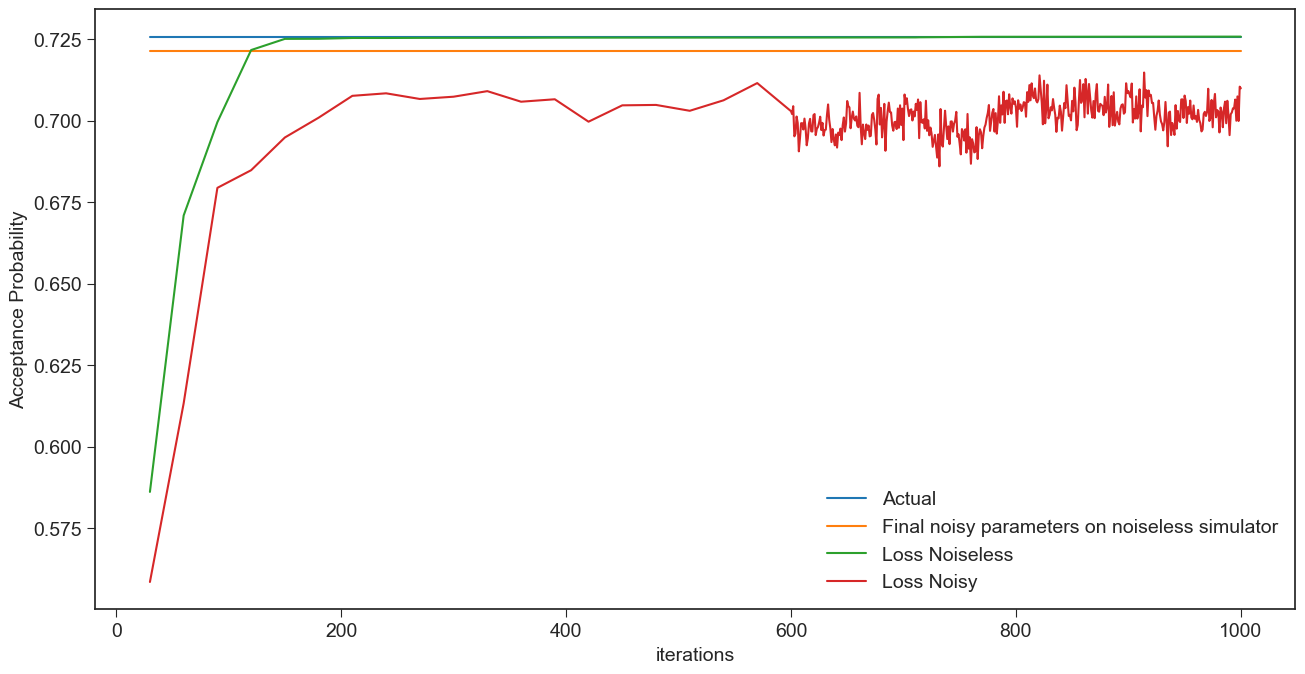

In [75]:
def plot_loss():
    '''
    Plots loss function. Actual normalized diamond distance value can be calculated using SDP.
    '''
    start = 1
    end = 1500
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(iteration[start:end], createActual(0.5*(1+0.45158228621024654), len(loss[start:end])), label = 'Actual')
    ax.plot(iteration[start:end], createActual(0.721211574431311, len(loss[start:end])), label = 'Final noisy parameters on noiseless simulator')
    ax.plot(iteration[start:end], loss_noiseless[start:end], 'tab:green', label='Loss Noiseless')
    ax.plot(iteration[start:end], loss_noisy[start:end], 'tab:red', label='Loss Noisy')
    plt.ylabel('Acceptance Probability')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()
plot_loss()

In [69]:
#Calculate diamond distance from Acceptance Probability
ddist_noiseless = [2*i-1 for i in loss_noiseless]
ddist_noisy = [2*i-1 for i in loss_noisy]

<ipython-input-85-2bfe0f393864>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("DiamondDistanceNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
<ipython-input-85-2bfe0f393864>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("DiamondDistanceNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


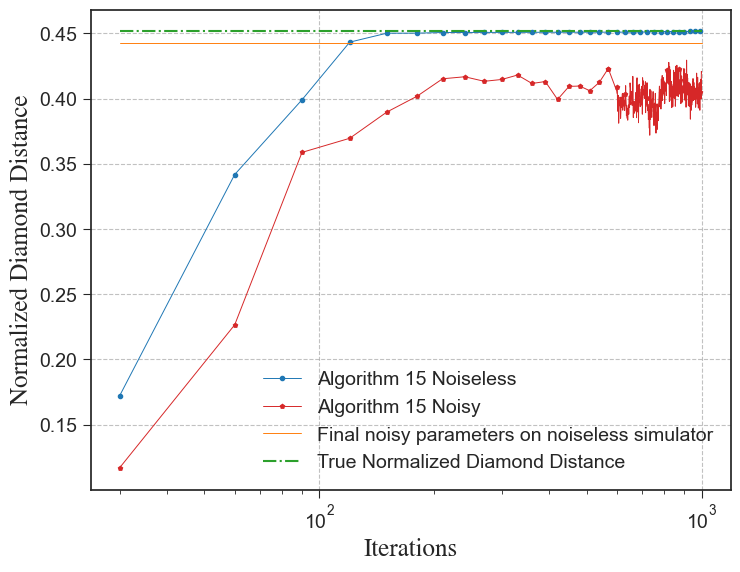

In [85]:
'''
To generate graph Figure 15 from https://arxiv.org/pdf/2108.08406.pdf
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, LogLocator
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import rc

#import rhinoscriptsytnax as rs

c1 = '#14A76C'
c6 = '#AC3B61'
c4 = '#2B7A78'
c2 = '#2E9CCA'
c5 = '#29648A'
c3 = '#F76C6C'

#m,c,k,g,r,b

#plt.rcParams['text.usetex'] = True
timesfont = {'fontname':'Times'}
style.use('seaborn-ticks')

start = 1
end = len(loss)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Plot and show our data
ax.plot(iteration[start:20], ddist_noiseless[start:20],'-o', markersize=3, markevery=1, color = '#1f77b4', linewidth=0.7, label = 'Algorithm 15 Noiseless')
ax.plot(iteration[21:], ddist_noiseless[21:],'-o', markersize=3, markevery=30, color = '#1f77b4', linewidth=0.7)

ax.plot(iteration[start:20], ddist_noisy[start:20],'-p', markersize=3, markevery=1, color = "#d62728", linewidth=0.7, label = 'Algorithm 15 Noisy')
ax.plot(iteration[19:22], ddist_noisy[19:22],'-p', markersize=3, markevery=30, color = "#d62728", linewidth=0.7)
ax.plot(iteration[22:], ddist_noisy[22:],'-p', markersize=3, markevery=30, color = "#d62728", linewidth=0.7)

ax.plot(iteration[start:], createActual(2*0.721211574431311-1, len(ddist_noisy[start:])),'-p', markersize=0, markevery=1, color = '#ff7f0e', linewidth=0.7, label = 'Final noisy parameters on noiseless simulator')
ax.plot(iteration[start:end], createActual(0.45158228621024654, len(loss[start:end])), '-.', color = '#2ca02c', label = 'True Normalized Diamond Distance')

ax.set_xscale('log')
#ax.set_xlim(0, 1600)

ax.grid(b=True, which='major', color='#666666', linestyle='--',alpha=0.4)
ax.legend(loc=0)
ax.set_xlabel('Iterations',**timesfont,fontsize =18)
ax.set_ylabel('Normalized Diamond Distance',**timesfont,fontsize =18)
plt.savefig("DiamondDistanceNoisy.pdf", dpi=2000, format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()